# Exercise: Titanic Dataset - Find and Visualize Missing Data

It is quite common for datasets to hold data in different formats (such as numbers, characters, meaningful words and even complex data such as images and sound).

To complicate things, datasets are not guaranteed to be complete! Missing data can be hard to spot at a first glance.

In this exercise we use a dataset of passengers from the Titanic ship to identify any missing data it might have (if you are curious, it can be analized and downloaded from this link: [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview)).

## Preparing data

The dataset contains columns describing passenegers from the first (and only) Titanic trip. They are described by fields indicating their socio-economic class, age, gender, whether they had family related travellers on board and if they survived (a full description can be found in the link above).

Let's use Pandas to load the dataset and take a cursory look at it:


In [68]:
import pandas as pd

# Load data from our dataset file into a pandas dataframe
dataset = pd.read_csv('Data/titanic.csv', index_col=False, sep=",",header=0)

# Let's take a look at the data
dataset.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Again, we can use `dataset.head()` to quickly examine the data.

Using `dataset.shape` let's us know how many samples and columns we have:



In [69]:
print(dataset.shape)

(891, 12)


The `shape` property indicates we have data for 891 passengers, each described by 12 different variables.

## Finding Missing Data

Unfortunally, we can't tell for sure if there's any data missing just by using `dataset.head()`.

We could print the entire dataset, but this would be prone to human error and impractical if you had thousands of samples.

A better options is to use `pandas` to report columns that have "empty" cells:

In [70]:
# Calculate the number of empty cells in each column
# and store it in a new dataframe
missing_data = dataset.isnull().sum().to_frame()

# Rename column holding the sums
missing_data = missing_data.rename(columns={0:'Empty Cells'})

# Print the results
print(missing_data)

             Empty Cells
PassengerId            0
Survived               0
Pclass                 0
Name                   0
Sex                    0
Age                  177
SibSp                  0
Parch                  0
Ticket                 0
Fare                   0
Cabin                687
Embarked               2


As suspected, there's a few gaps in the dataset.

We don't know the age of 177 passengers and whether 2 of them even embarked.

Cabin information for a whopping 687 persons is also missing.


## Missing Data Visualizations

There's a few ways we can plot the absence of data.

In the following examples we use the [missingno](https://pypi.org/project/missingno/) package to plot charts that display the geps in the dataset:

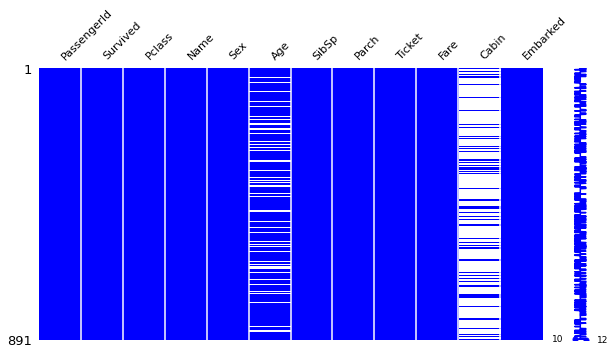

In [71]:
# import missingno package
import missingno as msno

# Plot a matrix chart, set chart and font size, set color to blue
msno.matrix(dataset, figsize=(10,5), fontsize=11, color=(0, 0, 1.0));


In [ ]:
While the chart above is very useful to spot large gaps (such as in "Age" and "Cabin"), it makes it hard to visually spot small ones like in "Embarked", where there is only two unknown values.

But we can explore another option:

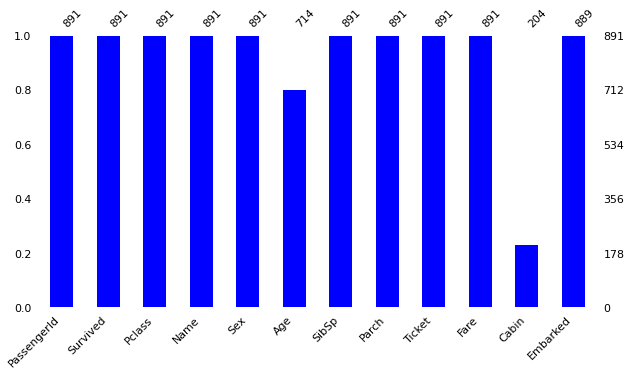

In [72]:
# Plot a barchart with blue bars, set chart and font size
msno.bar(dataset, color="blue", figsize=(10,5), fontsize=11);


The barchart displays the count of known values as column headers, making it easier to spot small discrepancies.

## Identifying Individual Passengers with Missing Information.

Let's use pandas to get a list of passengers whose age we don't know:

In [73]:
# Select Passengers with unknown age
unknown_age = dataset[dataset["Age"].isnull()]

# Print only the colums we want for the moment (to better fit screen)
# limit output to 20 rows
print(unknown_age[["PassengerId","Name", "Survived"]][:20])


    PassengerId                                            Name  Survived
5             6                                Moran, Mr. James         0
17           18                    Williams, Mr. Charles Eugene         1
19           20                         Masselmani, Mrs. Fatima         1
26           27                         Emir, Mr. Farred Chehab         0
28           29                   O'Dwyer, Miss. Ellen "Nellie"         1
29           30                             Todoroff, Mr. Lalio         0
31           32  Spencer, Mrs. William Augustus (Marie Eugenie)         1
32           33                        Glynn, Miss. Mary Agatha         1
36           37                                Mamee, Mr. Hanna         1
42           43                             Kraeff, Mr. Theodor         0
45           46                        Rogers, Mr. William John         0
46           47                               Lennon, Mr. Denis         0
47           48                       

For the above example we output only 20 rows and selected columns. 

This technique can be used to list the passengers with missing "Cabin" or "Embarked" information as well.


## Summary

Missing values can adversely affect the way a Machine Learning model works, so it is important to quickly verify if there are gaps in the data and where they are located.

You are now able to get a "big picture" of what is missing, by using lists and charts, and also to select only the specific items that need to be addressed.